In [1]:
import os
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim 

In [31]:
class Config():

    epoch_num = 100
    retrain_epoch_num = 1
    platform = "cpu"
    # -----------
    # child 
    # -----------
    
    # model
    class_num = 10
    child_num_layers = 6
    child_out_channels = 32
    child_num_op = 5
    # training
    child_data_path = './data/cifar-10-batches-py/'
    child_num_valids = 5000
    child_batch_size = 64
    # cosine learning 
    child_lr_init = 0.05
    child_lr_gamma = 0.1
    child_lr_cos_lmin = 0.001
    child_lr_cos_Tmax = 2
    # weight decay 
    child_l2_reg = 1e-4

    child_run_loss_every = 100
    # validate shared parameters
    child_valid_every_epochs = 1
    

    # -----------
    # controller 
    # -----------
    # model
    ctrl_lstm_size = 64
    ctrl_lstm_num_layers = 2
    # child
    # --- training
    ctrl_train_step_num = 10 # number of training steps per epoch
    ctrl_batch_size = 5 # number of samples per training step
    ctrl_train_every_epochs = 1
    # learning scheduler = exponential decaying
    ctrl_lr_init = 0.0001
    ctrl_lr_gamma = 0.1
    # baseline - reduce high variance; exponential moving average
    ctrl_baseline_decay = 0.999
    # prevent from being permature of controller
    # applied to logits
    ctrl_temperature = 5
    ctrl_tanh_constant = 2.5
    # add entropy to reward
    ctrl_entropy_weight = 0.0001
    # enforce skip sparsity 
    # add skip penalty to loss
    ctrl_skip_target = 0.4
    ctrl_skip_weight = 0.8
    # validate/test controller 
    ctrl_valid_every_epochs = 1
    ctrl_eval_arc_num = 2
    ctrl_final_arc_num = 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pickle 
import torch

def unpickle(file):
    """
    Read a batch
    """
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def _read_data(file_list):
    """
    Read a dataset and reshape it
    args: 
        file_list: path of dataset
    returns:
        data_set: all data
            format NCHW: x, 3072 -> x, 3, 32, 32
        label_set: all labels of the data
    """
    for i in range(len(file_list)):
        file = file_list[i]
        if DEBUG: print(file)
        data_batch = unpickle(file)
        data = data_batch[b'data']
        data = data.astype('float32')   # change to 
        data = data.reshape((-1, 3, 32, 32))
        labels = np.array(data_batch[b'labels']).astype('int')
        if i == 0:
            data_set = data
            label_set = labels
        else:
            data_set = np.concatenate((data_set, data), axis = 0)
            label_set = np.concatenate((label_set, labels), axis = 0)
        # if DEBUG:
        #     print(data.shape)
        #     print(labels.shape)


    return (data_set, label_set)

def read_data(data_path, num_valids=5000):
    """
    Read train/valid/test data sets
    args: 
        num_valids: num of images in a valid set
    returns:
        images: N, C, H, W
            in case of CIFAR-10, it consists of 
            
            train: 
                no valid set: 50k
                with valid set: 45k
            test:
                10k
            valid
                last 5k of training set
        label_set: all labels of the datasets
    """
    # create the file list
    # data_path = 'F:/2 Work/0 Solo/data/cifar-10-python/'
    train_files = []
    for i in range(5):
        # train_files.append('../data/cifar-10-python/data_batch_' + str(i+1))
        train_files.append(data_path + 'data_batch_' + str(i+1))
        # path:
            # F:\2 Work\0 Solo invented by InvisibleForce\pytorch\data\cifar-10-batches-py
    test_files = []
    test_files.append(data_path + 'test_batch')

    # create image and label dict
    images, labels = {}, {}
    # read train set
    images['train'], labels['train'] = _read_data(train_files)
    # read valid set
    if num_valids: # need
        # valid set
        images['valid'] = images['train'][-num_valids:] # last num_valids images
        labels['valid'] = labels['train'][-num_valids:]
        # train set = the remaining orginal train set
        images['train'] = images['train'][:-num_valids] # last num_valids images
        labels['train'] = labels['train'][:-num_valids]

    # read test set
    images['test'], labels['test'] = _read_data(test_files)


    # normalize data
    # 1. sub mean
    # 2. divide std
    # proc train set
    images['train'] = normalize(images['train'])
    # convert data to tensor
    images['train'] = torch.from_numpy(images['train'])
    # proc valid set
    if num_valids:
        images['valid'] = normalize(images['valid'])
        images['valid'] = torch.from_numpy(images['valid'])
    # proc test set
    images['test'] = normalize(images['test'])
    images['test'] = torch.from_numpy(images['test'])
    # convert labels from np array to torch.tensor.long
    labels['train'] = torch.from_numpy(labels['train'])
    labels['train'] = labels['train'].long()
    if num_valids:
        labels['valid'] = torch.from_numpy(labels['valid'])
        labels['valid'] = labels['valid'].long()
    labels['test'] = torch.from_numpy(labels['test'])
    labels['test'] = labels['test'].long()
    return images, labels

def normalize(dataset):
    """
    1. sub mean
    2. divide std
    arg:
        img: dataset, (N, C, H, W)
    return: 
        img: normalized dataset
    """

    dataset = np.transpose(dataset, [0, 2, 3, 1]) # NCHW -> NHWC
    dataset = dataset / 255.0 # 0-255 -> 0-1
    mean = np.mean(dataset, axis=(0, 1, 2), keepdims=True)
    std = np.std(dataset, axis=(0, 1, 2), keepdims=True)
    dataset = (dataset - mean) / std 
    dataset = np.transpose(dataset, [0, 3, 1, 2]) # NHWC -> NCHW

    return dataset

def augment(batch):
    """
    Processed on GPU
    1 upsample: 32x32 -> 40x40
    2 randomly crop: 40x40 -> 32x32
    3 flip horizontally: left -> right
    arg:
        img: a batch of images, (N, C, H, W)
    return: 
        img: augmented batch
    """
    # convert batch from tensor to nparray
    # batch = batch.data.numpy() # only supported by cpu devices
    if DEBUG: print('augment', type(batch))
    # parameters
    N, C, H, W = batch.size()
    # augment
    # for i in range(N):
    # img = batch[i, :, :, :]
    # 1 upsample: 32x32 -> 40x40 (H, W)
    batch = pad(batch, [[4, 4], [4, 4]])
    # 2 randomly crop: 40x40 -> 32x32
    batch = crop(batch, [H, W])
    # 3 flip horizontally: left -> right
    batch = flip_left_right(batch)
    # store it back to batch
    # batch[i, :, :, :] = img_flip

    # batch = torch.from_numpy(batch) # only for cpu
    if DEBUG: print('augment', type(batch))
    return batch 

def pad(batch, pad_size):
    """
    pad zeros to an img
    arg:
        img: an image, (C, H, W)
        pad_size: [[C_before, C_after], [H_top, H_bottom], [W_left, W_right]]
    return: 
        img: a zero-padded img
    """
    # params
    N, C, H, W = batch.size()
    H_zeros, W_zeros = pad_size
    # zero padding
    H_zp = H + H_zeros[0] + H_zeros[1]
    W_zp = W + W_zeros[0] + W_zeros[1]
    batch_zp = torch.zeros((N, C, H_zp, W_zp)).cuda()
    # batch_zp = batch_zp
    batch_zp[:, :, H_zeros[0] : H_zeros[0] + H, W_zeros[0] : W_zeros[0] + W] = batch
    
    return batch_zp

def crop(batch, crop_size):
    """
    randomly crop img to a smaller one
    arg:
        img: an image, (C, H, W)
        crop_size: [C_crop, H_crop, W_crop]
    return: 
        img_crop: a cropped img
    """
    # parameter
    N, C, H, W = batch.size()
    H_crop, W_crop = crop_size
    H_diff = H - H_crop + 1
    W_diff = W - W_crop + 1
    # randomly sample the crop offset
    H_offset = int(np.random.randint(0, H_diff, size=1))
    W_offset = int(np.random.randint(0, W_diff, size=1))
    # crop the img
    batch_crop = batch[:, :, H_offset : H_offset + H_crop, W_offset : W_offset + W_crop]

    return batch_crop

def flip_left_right(batch):
    """
    flip img from left to right. 
    CHW data format needs to flip axis=2 (i.e., W-axis) 
    arg:
        img: an image, (C, H, W)
    return: 
        img_flip: a left-right-flipped img 
    """
    # img_flip = np.flip(img, axis=2)
    # batch = torch.flip(batch, )
    batch = batch.flip(3) # flip along w-axis

    return batch



def test_data_proc():
    images, labels = read_data()
    batch = images['train'][0:3]
    print(batch[0, 0, 5, :])
    print(torch.sum(batch))
    batch_aug = augment(batch)
    print(batch_aug[0, 0, 5, :])
    print(torch.sum(batch_aug))
    # diff = batch - batch_aug
    # print(batch)
    # print(batch_aug)
    # print(diff)
    print(batch.shape)
    print(batch_aug.shape)

In [4]:
import os
import sys
# installed
import numpy as np
import torch 
import torch.nn as nn

DEBUG = 0


def global_avgpool(x):
    """
    An operation used to reduce the H and W axis
    x = [N, C, H, W] -> [N, C, 1, 1]
    """
    H = x.size()[2]
    W = x.size()[3]
    x = torch.sum(x, dim=[2, 3])
    x = x / (H * W)

    return x

# TODO: rename LayserOp as NodeOp
class Operation(nn.Module):
    """
    An operation used by a nas layer
    Args:
        op: conv1, conv3, conv5, avgpool3, maxpool3
        out_channels: = M, num of filters
    """
    def __init__(self, op, out_channels):
        super(Operation, self).__init__() 
        self.op = op 
        self.out_channels = out_channels
        self.layers = self._build_layer()
    
    def _build_layer(self):
        
        layers = []
        
        # kernel
        if self.op == 'conv1':
             kernel = nn.Conv2d(
            in_channels=self.out_channels, 
            out_channels=self.out_channels, 
            kernel_size = 1, 
            padding=(0,0), 
            stride=1)
        elif self.op == 'conv3':
            kernel = nn.Conv2d(
            in_channels=self.out_channels, 
            out_channels=self.out_channels, 
            kernel_size = 3, 
            padding=(1,1), # (3-1)/2
            stride=1)
        elif self.op == 'conv5':
            kernel = nn.Conv2d(
                in_channels=self.out_channels, 
                out_channels=self.out_channels, 
                kernel_size = 5, 
                padding=(2,2), # (5-1)/2
                stride=1)
        elif self.op == 'avgpool3':
            kernel = nn.AvgPool2d(
                kernel_size=3, 
                padding=(1,1),
                stride=1)
        elif self.op == 'maxpool3':
            kernel = nn.MaxPool2d(
                kernel_size=3, 
                padding=(1,1),
                stride=1)
        layers.append(kernel)
        # bn_out
        if (self.op == 'conv1') or (self.op == 'conv3') or (self.op == 'conv5'):
            layers.append(nn.ReLU(inplace=True))

        layers = nn.Sequential(*layers)

        return layers

    def __call__(self, x):
        
        return self.layers(x)
        

class Node(nn.Module):
    def __init__(self, out_channels=24):
        super(Node, self).__init__()
        """
        Create a nas layer
        """
        self.out_channels = out_channels
        
        self.layers = self._build_nas_layer()
        
        self.bn_out = nn.BatchNorm2d(num_features=self.out_channels)
        

    def _build_nas_layer(self):
        """
        build a nas layer consisting all possible branches
        """
        layers = []
        # conv1, 0
        conv1 = Operation('conv1', self.out_channels)
        layers.append(conv1)
        # conv3, 1
        conv3 = Operation('conv3', self.out_channels)
        layers.append(conv3)
        # conv5, 2
        conv5 = Operation('conv5', self.out_channels)
        layers.append(conv5)
        # avgpool3, 3
        avgpool3 = Operation('avgpool3', self.out_channels)
        layers.append(avgpool3)
        # maxpool3, 4
        maxpool3 = Operation('maxpool3', self.out_channels)
        layers.append(maxpool3)
        # create a module list
        layers = nn.ModuleList(layers)
    
        return layers

    def layer_op(self, x, op):
        """
        Run the operation of a nas layer
        Args:
            x: in_map
            op: operation to run
                0 - conv1
                1 - conv3
                2 - conv5
                3 - avgpool3
                4 - maxpool3
        Returns:
            x: out_map
        """
        x = self.layers[op](x)
        
        return x
        
    def skip(self, prev_layers, connections):
        """
        Concate the desired preve layers of a nas layer
        Args:
            prev_layers: previous layers
            config: describe all the combined layers
        Returns:
            y: ofmap
        """
        # add all the desired prev layers together
        offset = 1
        num_layer = len(prev_layers)-offset
        x = []
        for i in range(num_layer):
            if connections[i]:
                x.append(prev_layers[i+offset])
        if len(x):
            x = torch.stack(x) # stack all the tensors in an additional axis (i.e., 0)
            x = torch.sum(x, dim=0) # add along axis 0
        else:
            x = torch.zeros(prev_layers[0].size()) .cuda()
        return x


    def __call__(self, cnt_layer, prev_layers, op, connections):
        """
        describe the forward of the layer
        Args:
            prev_layers: all previous layers
            layer_config: op and connectivity
        """
        x = prev_layers[-1]
        # run op of the enas layer
        x = self.layer_op(x, op)
        if cnt_layer > 0:
            # combine the skip (add skips with x)
            y = self.skip(prev_layers, connections)
            # if DEBUG: print('skip_out\n', y.data)
            # combine op and skip results
            # gpu not supporting x + y
            x = torch.stack([x, y])
            x = torch.sum(x, dim=0)
            x = self.bn_out(x) 
        return x

In [5]:
class ChildModel(nn.Module):
    def __init__(self,
               class_num,
               num_layers=6,
               out_channels=24,
               batch_size=32
              ):
        """
        1. init params
        2. create a graph which contains the sampled subgraph
        """
        super(ChildModel, self).__init__() # init the parent class of Net, i.e., nn.Module
        # data set used for training, validating, testing
        self.class_num = class_num 
        # parameters for building a child model
        self.num_layers = num_layers # 
        self.out_channels = out_channels
        # build DAG = net
        self.head = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=self.out_channels, kernel_size = 3, padding=(1,1),stride=1),
            nn.BatchNorm2d(num_features=self.out_channels),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.graph = self._build_graph(self.class_num)
        # fc for final classification
        self.tail = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=self.out_channels, out_channels=self.out_channels, kernel_size = 3, padding=(1,1),stride=1),
            nn.BatchNorm2d(num_features=self.out_channels),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc = nn.Linear(self.out_channels, class_num, bias=True) 
        

    def _build_graph(self, class_num):
        graph = []
        
        # major part of the graph consisting of all NasLayers
        for _ in range(self.num_layers):
            graph.append(Node(self.out_channels))
        # create a ModuleList, or the parameters cannot be added
        graph = nn.ModuleList(graph)

        return graph

    # TODO: no reduction !
    def model(self, x, ops,skips):
        """
        run (like forward) a child model determined by sample_arch
        Args:
            sample_arch: a list consisting of 2 * num_layers elements
                op_id = sample_arch[2k]: operation id
                skip = sample_arch[2k + 1]: element i of such binary vector 
                    is used to describe whether the previous layer i is used 
                    as an input
            x: input of the child model
        Return:
            x: output of the child model
        """
        # layers
        prev_layers = []
        # stem_conv
        x = self.head(x)
        prev_layers.append(x)
        # nas_layers
        for cnt_layer in range(self.num_layers):
            x = self.graph[cnt_layer]( cnt_layer,prev_layers, ops[cnt_layer],skips[cnt_layer])
            prev_layers.append(x)
        # global_avgpool
        x = self.tail(x)
        x = global_avgpool(x)
        # fc
        x = self.fc(x)

        return x

In [6]:
class Child(nn.Module):
    def __init__(self,
               class_num,
               num_layers=6,
               out_channels=24,
               batch_size=32,
               device='cpu', 
               lr_init=0.05,
               lr_gamma=0.1,
               lr_cos_lmin=0.001,
               lr_cos_Tmax=2,
               l2_reg=1e-4,
               run_loss_every=100
              ):
        """
        1. init params
        2. create a graph which contains the sampled subgraph
        """
        super(Child, self).__init__() 
        self.class_num = class_num # number of classes
        self.num_layers = num_layers # 
        self.out_channels = out_channels
        self.batch_size = batch_size
        self.run_loss_every = run_loss_every

        self.l2_reg = l2_reg

        self.lr_init = lr_init
        self.lr_gamma = lr_gamma
        self.lr_cos_lmin = lr_cos_lmin
        self.lr_cos_Tmax = lr_cos_Tmax

        self.device = device

        self.net = ChildModel(class_num, num_layers, out_channels)

        self.criterion = nn.CrossEntropyLoss()

        self.optimizer = optim.SGD([{'params': self.net.parameters(), 'initial_lr': self.lr_init}], lr=self.lr_init, weight_decay=self.l2_reg, momentum=0.9, nesterov=True)
        self.scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, self.lr_cos_Tmax, eta_min=self.lr_cos_lmin)
    
    def get_batch(self, images, labels, step):
        batch_size = self.batch_size
        batch_images = images[step * batch_size : (step + 1) * batch_size] 
        batch_labels = labels[step * batch_size : (step + 1) * batch_size] 

        return batch_images, batch_labels

    def train_epoch(self, ops, skips, images, labels, epoch, train_step):
        all_loss = 0.0
        running_loss = 0.0
        print('lr=', self.scheduler.get_last_lr())
        for step in range(train_step): 
            batch_inputs, batch_labels = self.get_batch(images, labels, step)
            self.optimizer.zero_grad()
            outputs = self.net.model(batch_inputs, ops,skips)
            loss = self.criterion(outputs, batch_labels)
            loss.backward()
            self.optimizer.step()
            
            # update running loss
            all_loss += loss.item()
            running_loss += loss.item()
            if step % self.run_loss_every == (self.run_loss_every - 1):
                print('Epoch %d, Iter %d /%d, loss: %.3f' %
                    (epoch + 1, step + 1,train_step, running_loss / self.run_loss_every))
                running_loss = 0.0
        self.scheduler.step()
        return all_loss / train_step

    def eval_mini(self, ops, skips, images, labels):    
        # validating
        # get a minibatch for cpu or gpu
        high = labels.size()[0] // self.batch_size
        
        batch_idx = torch.randint(high, (1,1))
        # batch_idx = random.randint(0, high)
        batch_inputs, batch_labels = self.get_batch(images, labels, batch_idx)
        
        # forward
        with torch.no_grad():
            outputs = self.net.model(batch_inputs, ops,skips)
        
        # cal accuracy
        _, idx = torch.topk(outputs, 1)
        idx = idx.reshape((-1))
        accuracy = (idx == batch_labels).float().sum()
        accuracy /= self.batch_size
        
        return accuracy

    def eval(self, sample_arch, images, labels):
        step_num = labels.size()[0] // self.batch_size
        total_accuracy = 0
        for i in range(step_num):
            batch_inputs, batch_labels = self.get_batch(images, labels, i)
            with torch.no_grad():
                outputs = self.net.model(batch_inputs, sample_arch)
            _, idx = torch.topk(outputs, 1)
            idx = idx.reshape((-1))
            total_accuracy += (idx == batch_labels).float().sum() # count the correct prediction
        total_accuracy /= (step_num * self.batch_size)
        
        return total_accuracy

In [7]:
import torch.nn.functional as f

class StackLSTM(nn.Module):
    """
    StackLSTM class.
    It describes a stacked LSTM which only 
    run a single step.
    """
    def __init__(self, input_size, hidden_size, lstm_num_layers=2):
        super(StackLSTM, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lstm_num_layers = lstm_num_layers
        
        self.net = self._build_net()

    def _build_net(self):
        
        net = []
        for _ in range(self.lstm_num_layers):
            layer = nn.LSTMCell(self.input_size, self.hidden_size)
            net.append(layer)
        net = nn.ModuleList(net)

        return net

    def __call__(self, inputs, prev_h, prev_c):
        """
        Forward of stacked LSTM
        Args:
            inputs: input of the stack lstm, [batch=1, input_size]
            prev_h & prev_c: hidden and cell states of each layer at the previous time step.
                size = [lstm_num_layer, hidden_size]
        Returns:
            next_h & next_c
        """
        net = self.net
        next_h, next_c = [], []
        for i in range(self.lstm_num_layers):
            if i == 0: x = inputs
            else: x = next_h[-1]
            cur_h, cur_c = net[i](x, (prev_h[i], prev_c[i]))
            next_h.append(cur_h)
            next_c.append(cur_c)
        
        return next_h, next_c

class ControllerModel(nn.Module):
    
    def __init__(self,
               child_num_layers=6,
               lstm_size=32,
               lstm_num_layers=2,
               num_op=4,
               temperature=5,
               tanh_constant=2.5,
               skip_target=0.4,
               device='gpu'
              ):
        """
        1. init params
        2. create a graph which contains the sampled subgraph
        """
        super(ControllerModel, self).__init__() # init the parent class of Net, i.e., nn.Module
        # parameters for building a child model
        self.child_num_layers = child_num_layers # 
        # parameters for building a controller
        self.lstm_size = lstm_size
        self.lstm_num_layers = lstm_num_layers
        self.num_op = num_op
        self.temperature = temperature
        self.tanh_constant = tanh_constant
        self.skip_target = skip_target
        # build controller = net
        # claim all the layers and parameters
        self.net = self._build_net()
        # add g_emb as a parameter to ControllerModel
        # initialized by uniform distribution between -0.1 to 0.1
        # 0 <= torch.rand < 1
        g_emb_init = 0.2 * torch.rand(1,self.lstm_size) - 0.1
        self.register_parameter(name='g_emb', param=torch.nn.Parameter(g_emb_init))
        # results of net sample
        self.sample_arch = []
        self.sample_entropy = []
        self.sample_log_prob = []
        self.sample_skip_count = []
        self.sample_skip_penaltys = []
        

    def _build_net(self):

        net = {}
        # layers & params shared by op and skip
        net['lstm'] = StackLSTM(self.lstm_size, self.lstm_size, self.lstm_num_layers)
        # layers & params used only by op
        net['op_fc'] = nn.Linear(self.lstm_size, self.num_op)
        net['op_emb_lookup'] = nn.Embedding(self.num_op, self.lstm_size)
        # layers & params used only by skip
        net['skip_attn1'] = nn.Linear(self.lstm_size, self.lstm_size) # w_attn1 
        net['skip_attn2'] = nn.Linear(self.lstm_size, self.lstm_size) # w_attn2)
        net['skip_attn3'] = nn.Linear(self.lstm_size, 1)              # v_attn
        net = nn.ModuleDict(net)
        
        return net

    def _op_sample(self, args):
        """
        sample an op (it is a part of controller's forward)
        Args: consisting of the following parts
            inputs: input of op_sample
            prev_h & prev_c: the hidden and cell states of the prev layer
            arc_seq: architecture sequence
            log_probs: all the log probabilities used for training (recall the gradient calculation of REINFORCE)
            entropys: all the entropys used for training
        Return:
            x: output of the child model
        """
        net = self.net
        inputs, prev_h, prev_c, arc_seq, log_probs, entropys = args
        # lstm - process hidden states
        next_h, next_c = net['lstm'](inputs, prev_h, prev_c)
        prev_h, prev_c = next_h, next_c
        # fc - calculate logit
        logit = net['op_fc'](next_h[-1])    # h state of the last layer
        # temperature
        if self.temperature is not None:
            logit /= self.temperature
        # tanh and then scaled by a constant
        if self.tanh_constant is not None:
            logit = self.tanh_constant * torch.tanh(logit)
        # use softmax transfer logits to probs
        # or the logits may be negative it can not represent a prob
        prob = f.softmax(logit, dim=1)
        # multinomial for sampling an op
        op_id = torch.multinomial(prob, 1) # logit = probs of each type of operation, 1 = sample a single op
        op_id = op_id[0]
        # generate input for skip_sample using embedding lookup
        inputs = net['op_emb_lookup'](op_id.long())
        # calculate log_prob
        log_prob = f.cross_entropy(logit, op_id)
        # calculate entropy
        entropy = log_prob * torch.exp(-log_prob)
        # add op to arc_seq
        op = int(op_id.cpu().data.numpy()) # to an int
        arc_seq.append(op)
        # add to log_probs
        log_probs.append(log_prob)
        # add to entropys
        entropys.append(entropy)

        return inputs, prev_h, prev_c, arc_seq, log_probs, entropys        

    def _skip_sample(self, args):
        """
        sample skip connections for layer_id (it is a part of controller's forward)
        Args:
            layer_id
            inputs: input of op_sample
            prev_h & prev_c: the hidden and cell states of the prev layer
            arc_seq: architecture sequence
            log_probs: all the log probabilities used for training (recall the gradient calculation of REINFORCE)
            entropys: all the entropys used for training
            archors & anchors_w_1: archor points and its weighed values
            skip_targets & skip_penaltys & skip_count: used to enforce the sparsity of skip connections
        Return:
            all args except layer_id
        """    
        layer_id, inputs, prev_h, prev_c, arc_seq, log_probs, entropys, anchors, anchors_w_1, skip_targets, skip_penaltys, skip_count = args
        net = self.net
        # lstm - process hidden states
        next_h, next_c = net['lstm'](inputs, prev_h, prev_c)
        prev_h, prev_c = next_h, next_c
        if layer_id > 0:
            # use attention mechanism to generate logits
            # concate the weighed anchors
            query = torch.cat(anchors_w_1, dim=0) 
            # attention 2 - fc
            query = torch.tanh(net['skip_attn2'](next_h[-1]) + query)
            # attention 3 - fc            
            query = net['skip_attn3'](query)
            # generate logit
            logit = torch.cat([-query, query], dim=1)
            # process logit with temperature
            if self.temperature is not None:
                logit /= self.temperature
            # process logit with tanh and scale it
            if self.temperature is not None:
                logit = self.tanh_constant * torch.tanh(logit)
            # calculate prob of skip (see NAS paper, Sec3.3)
            skip_prob = torch.sigmoid(logit) # use sigmoid to convert skip to its prob
            # sample skip connections using multinomial distribution sampler
            skip = torch.multinomial(skip_prob, 1)  # 0 - used as an input, 1 - not an input
            # calcualte kl as skip penalty
            kl = skip_prob * torch.log(skip_prob / skip_targets) # calculate kl
            kl = torch.sum(kl)
            skip_penaltys.append(kl)
            # cal log_prob and append it - used by REINFORCE to calculate gradients of controller (i.e., LSTM)
            log_prob = f.cross_entropy(logit, skip.squeeze(dim=1))
            log_probs.append(torch.sum(log_prob))
            # cal entropys and append it
            entropy = log_prob * torch.exp(-log_prob)
            entropy = torch.sum(entropy)
            entropys.append(entropy)
            # update count of skips
            skip_count.append(skip.sum())
            arc_seq.append(skip.cpu().squeeze(dim=1).data.numpy().tolist())
            # generate inputs for the next time step
            skip = torch.reshape(skip, (1, layer_id)) # reshape skip
            cat_anchors = torch.cat(anchors, dim=0)
            # skip = 1 x layer_id (layer_id > 0) 
            # cat_anchors = layer_id x lstm_size
            inputs = torch.matmul(skip.float(), cat_anchors) 
            inputs /= (1.0 + torch.sum(skip))
        else:
            inputs = self.g_emb
            arc_seq.append([]) # no skip, use empty list to occupy the position
        
        # cal the
        anchors.append(next_h[-1])
        # cal attention 1
        attn1 = net['skip_attn1'](next_h[-1])
        anchors_w_1.append(attn1)

        return inputs, prev_h, prev_c, arc_seq, log_probs, entropys, anchors, anchors_w_1, skip_targets, skip_penaltys, skip_count

    def net_sample(self):
        """
        run (like forward) a controller model to sample an neural architecture
        Args:
            
        Return:
            
        """
        # net sample
        ops = []
        skips = []
        
        entropys = []
        log_probs = []
        # skip sample 
        anchors = []        # store hidden states of skip lstm; anchor = hidden states of skip lstm (i.e., layer_id)
        anchors_w_1 = []    # store results of attention 1 (input=h, w_attn1)
        skip_count = []
        skip_penaltys = []


        # init inputs and states
        # init prev cell states to zeros for each layer of the lstm
        prev_c = [torch.zeros((1, self.lstm_size)).cuda() for _ in range(self.lstm_num_layers)]
        # init prev hidden states to zeros for each layer of the lstm
        prev_h = [torch.zeros((1, self.lstm_size)).cuda() for _ in range(self.lstm_num_layers)]
        # inputs
        inputs = self.g_emb.cuda()
        # skip_target = 0.4 = the prob of a layer used as an input of another layer
        # 1 - skip_target = 0.6; the probability that this layer is not used as an input
        skip_targets = torch.tensor([1.0 - self.skip_target, self.skip_target], dtype=torch.float).cuda()
        

        # sample an arch
        for layer_id in range(self.child_num_layers):
            arg_op_sample = [inputs, prev_h, prev_c, ops, log_probs, entropys]
            returns_op_sample = self._op_sample(arg_op_sample)
            inputs, prev_h, prev_c, ops, log_probs, entropys = returns_op_sample
            arg_skip_sample = [layer_id, inputs, prev_h, prev_c, skips, log_probs, entropys, 
                                anchors, anchors_w_1, skip_targets, skip_penaltys, skip_count]
            returns_skip_sample = self._skip_sample(arg_skip_sample)
            inputs, prev_h, prev_c, skips, log_probs, entropys, anchors, anchors_w_1, skip_targets, skip_penaltys, skip_count = returns_skip_sample

        # generate sample arch
        # [[op], [skip]] * num_layer
        self.ops = ops
        self.skips = skips
        
        # cal sample entropy
        entropys = torch.stack(entropys)
        self.sample_entropy = torch.sum(entropys)
   
        # cal sample log_probs
        log_probs = torch.stack(log_probs)
        self.sample_log_prob = torch.sum(log_probs)
   
            
        # cal skip count
        skip_count = torch.stack(skip_count)
        self.sample_skip_count = torch.sum(skip_count)
     
        # cal skip penaltys
        skip_penaltys = torch.stack(skip_penaltys)
        self.sample_skip_penaltys = torch.sum(skip_penaltys)
        

In [8]:
class Controller(nn.Module):
    """
    Controller class.
    It describes how to train a controller
        1) train
    """
    def __init__(self,
               device='gpu',
               lstm_size=32,
               lstm_num_layers=2,
               child_num_layers=6,
               num_op=4,
               train_step_num=50,
               ctrl_batch_size=20,
               lr_init=0.00035,
               lr_gamma=0.1,
               temperature=5,
               tanh_constant=2.5,
               entropy_weight=0.0001,
               baseline_decay=0.999,
               skip_target=0.4,
               skip_weight=0.8
              ):
        super(Controller, self).__init__() # init the parent class of Net, i.e., nn.Module
        # config of controller model
        # child model
        self.child_num_layers = child_num_layers # imgs of dataset
        # ctrl model
        self.lstm_size = lstm_size # labels of dataset 
        self.lstm_num_layers = lstm_num_layers # number of classes
        self.num_op = num_op # 
        self.temperature = temperature
        self.tanh_constant = tanh_constant
        self.skip_target = skip_target
        # ctrl training
        self.ctrl_batch_size=ctrl_batch_size
        self.lr_init = lr_init
        self.lr_gamma = lr_gamma
        self.train_step_num = train_step_num
        self.entropy_weight = entropy_weight
        self.baseline_decay = baseline_decay
        self.skip_weight = skip_weight
        # device
        self.device = device
        # # training parameters on gpu
        self.reward = torch.zeros(1).cuda() # rewards of samples
        self.baseline = torch.zeros(1).cuda() # base line
        self.log_prob = torch.zeros(1).cuda() # log_probs of samples
        self.entropy = torch.zeros(1).cuda() # entropys of samples
        # self.skip_rate = torch.zeros(1) # skip_rates of samples
        self.skip_penalty = torch.zeros(1).cuda() # skip_penaltys of samples
        self.loss = torch.zeros(1).cuda() # loss


        # build controller
        self.ctrl = ControllerModel(child_num_layers=child_num_layers,
               lstm_size=lstm_size,
               lstm_num_layers=lstm_num_layers,
               num_op=num_op,
               temperature=temperature,
               tanh_constant=tanh_constant,
               skip_target=skip_target,
               device=device)
        self.optimizer = optim.Adam(self.ctrl.parameters(), lr=self.lr_init)
        
      
    
    def train_epoch(self, child_model, images, labels):    
        for step in range(self.train_step_num):
            loss = torch.zeros(self.ctrl_batch_size).cuda()
            for sample_cnt in range(self.ctrl_batch_size):
                # sample a child arch
                self.ctrl.net_sample()
                # valid a sampled arch and obtain reward
                self.reward = child_model.eval_mini(self.ctrl.ops,self.ctrl.skips, images, labels) 
                # add weighed entropy to reward
                self.entropy = self.ctrl.sample_entropy
                self.reward += self.entropy_weight * self.entropy
                # update baseline
                with torch.no_grad():
                    self.baseline = self.baseline + (1 - self.baseline_decay) * (self.reward - self.baseline)
                # update loss
                self.log_prob = self.ctrl.sample_log_prob
                self.skip_penalty = self.ctrl.sample_skip_penaltys
                loss[sample_cnt] = self.log_prob * (self.reward - self.baseline) + self.skip_weight * self.skip_penalty
            self.loss = loss.sum() / self.ctrl_batch_size # avg loss
            print(step,self.loss.item())
            self.optimizer.zero_grad()
            self.loss.backward()
            self.optimizer.step()
            
        return self.loss.item()


    def eval(self, child_model, arc_num, images, labels, file):
        """
        evaluate controller using validating data set.
        It samples several archs and validate them on 
        the whole validate set.
            
        Args:
            
        Return:
            
        """
        accuracy = []
        arcs = []
        for _ in range(arc_num):
            # sample a child arch
            self.ctrl.net_sample()
            arcs.append(self.ctrl.sample_arch)
            # valid a sampled arch and obtain reward
            eval_acc = child_model.eval(self.ctrl.ops,self.ctrl.skips, images, labels) 
            accuracy.append(eval_acc)
        # obtain averaged op_history
        return accuracy

    def derive_best_arch(self, child_model, arc_num, images, labels, file):
        """
        derive the final child model using controller
        procedure
            1. sample 1000 archs
            2. test them on test data set
            3. select the one with highest accuracy as the best arch
        Args:
            
        Return:
            best_arch
        """
        accuracy = []
        arcs = []
        best_arch = []
        best_accuracy = 0
        for _ in range(arc_num):
            # sample a child arch
            self.ctrl.net_sample()
            arcs.append(self.ctrl.sample_arch)
            # valid a sampled arch and obtain reward
            eval_acc = child_model.eval(self.ctrl.ops,self.ctrl.skips, images, labels) 
            accuracy.append(eval_acc)
            # select the best arch
            if eval_acc > best_accuracy:
                best_accuracy = eval_acc
                best_arch = self.ctrl.sample_arch

        return best_accuracy, best_arch

In [32]:
config = Config()

In [10]:
images, labels = read_data(config.child_data_path, config.child_num_valids)

In [11]:
torch.cuda.set_device(9)

In [33]:
child = Child(
        class_num=config.class_num,
        num_layers=config.child_num_layers,
        out_channels=config.child_out_channels,
        batch_size=config.child_batch_size,
        device=config.platform, 
        lr_init=config.child_lr_init,
        lr_gamma=config.child_lr_gamma,
        lr_cos_lmin=config.child_lr_cos_lmin,
        lr_cos_Tmax=config.child_lr_cos_Tmax,
        l2_reg=config.child_l2_reg,
        run_loss_every=config.child_run_loss_every
    )
child = child.cuda()

In [34]:
ctrl = Controller(
        device=config.platform,
        lstm_size=config.ctrl_lstm_size,
        lstm_num_layers=config.ctrl_lstm_num_layers,
        child_num_layers=config.child_num_layers,
        num_op=config.child_num_op,
        train_step_num=config.ctrl_train_step_num,
        ctrl_batch_size=config.ctrl_batch_size,
        lr_init=config.ctrl_lr_init,
        lr_gamma=config.ctrl_lr_gamma,
        temperature=config.ctrl_temperature,
        tanh_constant=config.ctrl_tanh_constant,
        entropy_weight=config.ctrl_entropy_weight,
        baseline_decay=config.ctrl_baseline_decay,
        skip_target=config.ctrl_skip_target,
        skip_weight=config.ctrl_skip_weight)
ctrl = ctrl.cuda()

In [14]:
train_imgs = images['train'].cuda()
train_labels = labels['train'].cuda()
valid_imgs = images['valid'].cuda()
valid_labels = labels['valid'].cuda()
test_imgs = images['test'].cuda()
test_labels = labels['test'].cuda()

In [35]:
train_step = int(train_imgs.size()[0] / config.child_batch_size)
child_loss = []
ctrl_loss = []

In [38]:
for epoch in range(50,100):
    print("epoch:",epoch)
    print('-------- train child --------')
    #sample an arch
    ctrl.ctrl.net_sample()
    ops = ctrl.ctrl.ops
    skips = ctrl.ctrl.skips
    print('ops',ops,'skips',skips)
    child_loss.append(child.train_epoch(ops,skips, train_imgs, train_labels, epoch, train_step))
    
    if (epoch + 1) % config.ctrl_train_every_epochs == 0:
        print('-------- train controller --------')
        ctrl_loss.append(ctrl.train_epoch(child, valid_imgs, valid_labels))

epoch: 50
-------- train child --------
ops [2, 1, 3, 1, 4, 3] skips [[], [0], [0, 0], [0, 1, 0], [0, 0, 1, 0], [0, 0, 1, 1, 0]]
lr= [0.001]
Epoch 51, Iter 100 /703, loss: 1.062
Epoch 51, Iter 200 /703, loss: 0.874
Epoch 51, Iter 300 /703, loss: 0.857
Epoch 51, Iter 400 /703, loss: 0.800
Epoch 51, Iter 500 /703, loss: 0.768
Epoch 51, Iter 600 /703, loss: 0.774
Epoch 51, Iter 700 /703, loss: 0.729
-------- train controller --------
0 1.4661896228790283
1 2.5530550479888916
2 2.8554046154022217
3 0.1619141548871994
4 3.155046224594116
5 1.8491363525390625
6 1.4369862079620361
7 2.286153793334961
8 1.4459104537963867
9 2.7358474731445312
epoch: 51
-------- train child --------
ops [2, 3, 3, 2, 3, 1] skips [[], [1], [0, 1], [1, 0, 0], [0, 1, 1, 0], [1, 0, 0, 0, 0]]
lr= [0.0255]
Epoch 52, Iter 100 /703, loss: 0.766
Epoch 52, Iter 200 /703, loss: 0.727
Epoch 52, Iter 300 /703, loss: 0.719
Epoch 52, Iter 400 /703, loss: 0.696
Epoch 52, Iter 500 /703, loss: 0.670
Epoch 52, Iter 600 /703, loss:

0 1.673848032951355
1 -0.6092326045036316
2 1.3084759712219238
3 0.794847309589386
4 2.3030173778533936
5 0.6458421945571899
6 1.2553131580352783
7 1.8796303272247314
8 1.2603249549865723
9 -0.3435123860836029
epoch: 63
-------- train child --------
ops [3, 3, 0, 2, 0, 2] skips [[], [1], [0, 0], [0, 1, 0], [1, 0, 0, 1], [1, 0, 0, 1, 0]]
lr= [0.0255]
Epoch 64, Iter 100 /703, loss: 0.875
Epoch 64, Iter 200 /703, loss: 0.771
Epoch 64, Iter 300 /703, loss: 0.755
Epoch 64, Iter 400 /703, loss: 0.732
Epoch 64, Iter 500 /703, loss: 0.694
Epoch 64, Iter 600 /703, loss: 0.718
Epoch 64, Iter 700 /703, loss: 0.683
-------- train controller --------
0 0.9141645431518555
1 -1.3834741115570068
2 0.52494215965271
3 1.7904014587402344
4 0.03290524706244469
5 1.6404606103897095
6 1.9648771286010742
7 0.9355465173721313
8 0.7637934684753418
9 0.4281182289123535
epoch: 64
-------- train child --------
ops [1, 1, 2, 1, 0, 2] skips [[], [0], [0, 1], [1, 1, 1], [0, 1, 1, 0], [1, 1, 1, 1, 1]]
lr= [0.04999999

Epoch 76, Iter 100 /703, loss: 0.764
Epoch 76, Iter 200 /703, loss: 0.676
Epoch 76, Iter 300 /703, loss: 0.680
Epoch 76, Iter 400 /703, loss: 0.660
Epoch 76, Iter 500 /703, loss: 0.633
Epoch 76, Iter 600 /703, loss: 0.654
Epoch 76, Iter 700 /703, loss: 0.623
-------- train controller --------
0 0.36815568804740906
1 -0.04733681678771973
2 2.2121732234954834
3 1.0700873136520386
4 1.0275686979293823
5 -0.2751164436340332
6 0.8712366223335266
7 -0.10570140182971954
8 1.4463050365447998
9 -0.6260887980461121
epoch: 76
-------- train child --------
ops [4, 4, 2, 2, 4, 2] skips [[], [0], [1, 0], [0, 0, 0], [1, 0, 0, 0], [1, 1, 1, 1, 1]]
lr= [0.05000000000000031]
Epoch 77, Iter 100 /703, loss: 0.951
Epoch 77, Iter 200 /703, loss: 0.830
Epoch 77, Iter 300 /703, loss: 0.810
Epoch 77, Iter 400 /703, loss: 0.782
Epoch 77, Iter 500 /703, loss: 0.749
Epoch 77, Iter 600 /703, loss: 0.779
Epoch 77, Iter 700 /703, loss: 0.741
-------- train controller --------
0 0.08655672520399094
1 0.49678388237953

1 0.49866676330566406
2 2.13791823387146
3 2.31473708152771
4 1.4980701208114624
5 -0.36563196778297424
6 1.9286867380142212
7 0.19664669036865234
8 1.2737441062927246
9 0.735497236251831
epoch: 88
-------- train child --------
ops [4, 3, 1, 4, 2, 1] skips [[], [0], [0, 0], [0, 0, 0], [1, 1, 0, 1], [0, 0, 0, 0, 0]]
lr= [0.05000000000000069]
Epoch 89, Iter 100 /703, loss: 1.028
Epoch 89, Iter 200 /703, loss: 0.866
Epoch 89, Iter 300 /703, loss: 0.835
Epoch 89, Iter 400 /703, loss: 0.820
Epoch 89, Iter 500 /703, loss: 0.775
Epoch 89, Iter 600 /703, loss: 0.797
Epoch 89, Iter 700 /703, loss: 0.756
-------- train controller --------
0 0.8970404863357544
1 0.24854981899261475
2 0.3365926444530487
3 0.1687115728855133
4 1.14104425907135
5 -1.8611043691635132
6 -0.07821585983037949
7 -0.8824300169944763
8 -0.3203905522823334
9 1.2530691623687744
epoch: 89
-------- train child --------
ops [4, 0, 3, 0, 2, 2] skips [[], [1], [1, 1], [1, 1, 1], [1, 0, 0, 0], [1, 0, 1, 1, 0]]
lr= [0.0255000000000

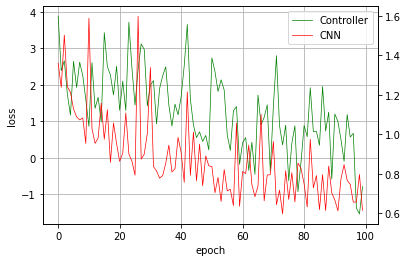

In [46]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc
rc('mathtext', default='regular')

fig = plt.figure()
ax = fig.add_subplot(111)
lns1 = ax.plot(np.arange(len(ctrl_loss)),ctrl_loss, '-', linewidth=0.7,color='green',label = 'Controller')
ax2 = ax.twinx()
lns2 = ax2.plot(np.arange(len(child_loss)),child_loss, '-', linewidth=0.7,color='red',label = 'CNN')

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)

ax.grid()
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
plt.show()

In [17]:
class BuildChildModel(nn.Module):
    def __init__(self,
               class_num,
               ops,
               skips,
               num_layers=6,
               out_channels=24,
               batch_size=32
              ):
        super(BuildChildModel, self).__init__() 
        self.class_num = class_num 
        self.num_layers = num_layers 
        self.out_channels = out_channels
        
        self.ops  = ops
        self.skips = skips
        self.head = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=self.out_channels, kernel_size = 3, padding=(1,1),stride=1),
            nn.BatchNorm2d(num_features=self.out_channels),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layers = self._build_layer(self.class_num)

        self.tail = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=self.out_channels, out_channels=self.out_channels, kernel_size = 3, padding=(1,1),stride=1),
            nn.BatchNorm2d(num_features=self.out_channels),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc = nn.Linear(self.out_channels, class_num, bias=True) 
        

    def _build_layer(self, class_num):
        layer = []
        
        # major part of the graph consisting of all NasLayers
        for i in range(self.num_layers):
            if self.ops[i] == 0:
                kernel = nn.Conv2d(
                in_channels=self.out_channels, 
                out_channels=self.out_channels, 
                kernel_size = 3, 
                padding=(1,1), # (3-1)/2
                stride=1)
            elif self.ops[i] == 1:
                kernel = nn.Conv2d(
                    in_channels=self.out_channels, 
                    out_channels=self.out_channels, 
                    kernel_size = 5, 
                    padding=(2,2), # (5-1)/2
                    stride=1)
            elif self.ops[i] == 2:
                kernel = nn.AvgPool2d(
                    kernel_size=3, 
                    padding=(1,1),
                    stride=1)
            elif self.ops[i] == 3:
                kernel = nn.MaxPool2d(
                    kernel_size=3, 
                    padding=(1,1),
                    stride=1)
            layer.append(kernel)
            # bn_out
            if (self.ops[i] == 0) or (self.ops[i] == 1):
                layer.append(nn.ReLU(inplace = True))
                layer.append()
        # create a ModuleList, or the parameters cannot be added
        layer = nn.ModuleList(layer)

        return layer

    # TODO: no reduction !
    def forward(self, x):
        """
        run (like forward) a child model determined by sample_arch
        Args:
            sample_arch: a list consisting of 2 * num_layers elements
                op_id = sample_arch[2k]: operation id
                skip = sample_arch[2k + 1]: element i of such binary vector 
                    is used to describe whether the previous layer i is used 
                    as an input
            x: input of the child model
        Return:
            x: output of the child model
        """
        # layers
        prev_layers = []
        # stem_conv
        x = self.head(x)
        # nas_layers
        for i in range(self.num_layers):
            x = self.layers[i](x)
            for j in range(i):
                if self.skips[i][j]:
                    x = x + prev_layers[j]
            prev_layers.append(x)
        # global_avgpool
        x = self.tail(x)
        x = global_avgpool(x)
        # fc
        x = self.fc(x)

        return x